In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from math import ceil,sin,cos, atan2, pi, sqrt
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions22 import *

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
path_bat = '/home/jvalenti/MOAD/grid/bathymetry_202108.nc'
bat = xr.open_dataset(path_bat,decode_times=False).Bathymetry

In [27]:
path_d='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_area='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_area='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_mask = '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TD.nc'
e3t = xr.open_dataset(path_d,decode_times=False).e3t
Area = xr.open_dataset(path_area,decode_times=False).area
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
zz_ww = xr.open_dataset(path_mask,decode_times=False).gdepw_0

In [106]:
path_w='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_W.nc'
np.nanmean(xr.open_dataset(path_w,decode_times=False).vert_eddy_diff[:,1,:,:])

0.006286951

In [110]:
Kz = 6e-3
np.sqrt(3*2*Kz*5)

0.42426406871192857

In [111]:
0.42/2.9e-4

1448.2758620689654

In [88]:
np.nanmax(90*(e3t[1,0,:,:]-e3t[0,0,:,:])/3600)

0.002347064

0.005222779512405395

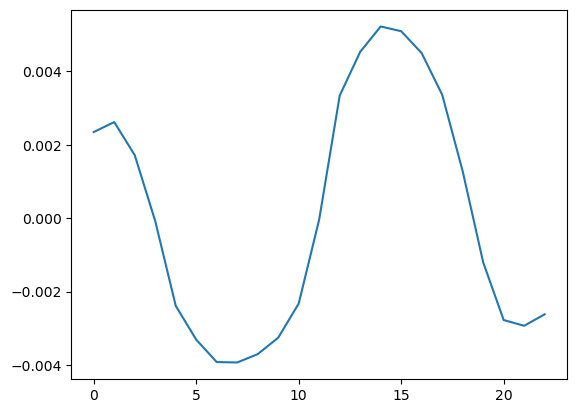

In [99]:
deltae3t = []
for i in range(23):
    deltae3t.append(90*((e3t[i+1,0,13,91]-e3t[i,0,13,91]))/3600)
plt.plot(deltae3t)
np.max(deltae3t)

In [59]:
mask = xr.open_dataset(path_mask,decode_times=False)

In [76]:
dimx = zz_ww.shape[3]
dimy = zz_ww.shape[2]
totaldepth = np.zeros_like(mbathy[0,:,:],dtype='float32')

for jj in range(dimy):
    totaldepth[jj, :] = zz_ww[0, mbathy[0,jj, :],jj, :]

In [77]:
mask['totaldepth'] = (['y','x'],totaldepth)

In [72]:
Dat=xr.open_dataset(path(0)['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [80]:
mask.to_netcdf('/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TD.nc')

In [3]:
ee3 = np.array(e3t[:,:,445,304])

In [4]:
eM = ee3[0,:]
em = ee3[10,:]
EM = np.cumsum(eM)
Em = np.cumsum(em)
eeM,eem = [EM[0]/2],[Em[0]/2]
for k in range(1,len(eM)):
    eeM.append(EM[k-1] + (EM[k]-EM[k-1])/2)
    eem.append(Em[k-1] + (Em[k]-Em[k-1])/2)
    

In [5]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
config='/home/jvalenti/MOAD/analysis-jose/OParcels/neutral_iona.yaml'

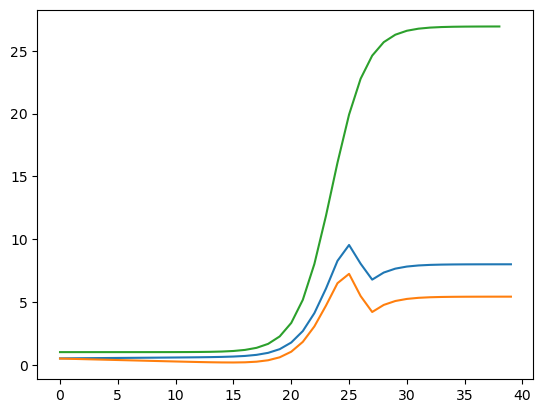

In [6]:
z = np.array(xr.open_dataset('/results2/SalishSea/nowcast-green.201905/31oct22/SalishSea_1h_20221031_20221031_grid_W.nc',decode_times=False).depthw)
plt.plot(-z+np.array(eeM))
plt.plot(-z+np.array(eem))
plt.plot(np.diff(z))
#plt.plot(-np.array(eeM))
#plt.plot(-np.array(eem))

In [37]:
param = load_config1(config)
start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
Tmax = param['param']['length'] # Set Time length [days] 
duration = timedelta(days=Tmax)
dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
N = param['param']['N'] # number of deploying locations
n = param['param']['n'] # 1000   # number of particles per location
dmin = param['param']['dmin'] #minimum depth
dd = param['param']['dd'] #max depth difference from dmin
name = param['file']['name'] #name output file

daterange = [start+timedelta(days=i) for i in range(Tmax)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)

In [58]:
def paths_vol (start,duration,dt):
    Arealist = []
    e3tlist = []
    for day in range(duration.days):
            path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
            Arealist.append(path_NEMO + '_grid_T.nc')
            e3tlist.append(path_NEMO + '_carp_T.nc')
    return Arealist, e3tlist
Arealist, e3tlist = paths_vol (start,duration,dt)


In [40]:
def paths_vol (start,duration):
    Arealist = []
    e3tlist = []
    for day in range(duration.days):
            path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
            Arealist.append(path_NEMO + '_grid_T.nc')
            e3tlist.append(path_NEMO + '_carp_T.nc')
    return Arealist, e3tlist
Arealist, e3tlist = paths_vol (start,duration)


In [55]:
# def Volume_cells(start,dt):
#     opsdir, namfmt, jlims, ilims = getWindVars(start)
#     flist=et.index_model_files(start,start+DeltaT,opsdir,namfmt,
#                             flen=1,ftype='None',tres=24);
#     fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
#     fu=xr.concat([ii['u_wind'].isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
#     fv=xr.concat([ii['v_wind'].isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
#     fud=xr.concat([ii['u_wind'].isel(x=72,y=62) for ii in fs],"time_counter")
#     fvd=xr.concat([ii['v_wind'].isel(x=72,y=62) for ii in fs],"time_counter")
#     Week1=(fu**2+fv**2)**(3/2)
#     wind=(fu**2+fv**2)**(1/2)
#     umean = np.nanmean(np.mean(fu,0))
#     vmean = np.nanmean(np.mean(fv,0))
#     Windir = np.arctan2(vmean,umean)
#     Week1mean=np.mean(Week1,0)
#     return np.nanmean(Windir), np.nanmean(Week1mean),np.nanmax(wind)
# Qwind = [] 
# Windir = [] 
# Mwind = []
# for i in range(1,104):
#     Wdr,Qww,Wmm = Qubicwind_tmean(start, timedelta(days= 7))
#     Mwind.append(Wmm)
#     Qwind.append(Qww)
#     Windir.append(Wdr)
#     start = start+timedelta(days= 7)